<a href="https://colab.research.google.com/github/6X10/advanced-statistical-data-analysis/blob/main/naive_bayes_classifier_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from time import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = sio.loadmat('/content/drive/MyDrive/Colab Notebooks/sentimentdataset.mat', chars_as_strings=1, matlab_compatible=1)

bagofword = data['bagofword']
sentiment = data['sentiment']
sentiment = sentiment.astype(int) #type을 0 or 1로 할 것
words = data['word']

# join character to word
# ex.) [['h', 'o', 'l', 'e', 's']]  -> "holes"
word = []
for n in range(20): #어떤 단어 있는지 앞에서부터 20개 뽑음 뽑음
    word = word + [str(''.join(letter)) for letter in words[n][0]]
print(word) #<num>처럼 숫자가 들어가는 자리는, number를 indacate하는 indicator로 변환해서 데이터가 존재하기도 하고 다양함. 단어 아닌 것도 있는데 편의상 단어라고 하자

['holes', 'must', 'top_secret', 'he', 'center', 'other_civilans', 'the_pacific', 'the_navy', 'a_lot', 'surface_must', 'this_book', 'man_named', '<num>_feet', 'would_strongly', 'put_down', 'norman_johnson', 'lawes', 'a_top', 'the_support', 'ten']


In [ ]:
numDoc = len(bagofword) # number of documents (총)
numTesting = 50 # number of testing documents
numVoca = 1000 # number of vocabs, use small number (ex. 1000) for debugging (단어장의 총 단어 개수. debugging할 때는 코드 빨리빨리 돌아야 하므로, 임의로 세팅해놓고 코드 잘 도는 거 확인하면서 하기)
step = (numDoc-numTesting)//10 # number of steps of increment of training documents (line 18번과 관련. 처음에는 10개의 document만, 그 다음에는 20, 30...개를 training data로 사용할 것 by for loop. 그래서 총 step 까지 iteration 돌리겠다)
repeat = 3 # number of repetition, use small number (ex. 3) for debugging (한 번 해서 나온 실험 결과는 믿을 수 없음. 최소 5번 반복해서 평균적인 성능(ex.average accuracy, 그것에 대한 standard deviation) report 꼭 해야. so, 여러번 실험해서 평균과 분산을 내자는 차원의 hyper parameter
alpha = 0. # Beta distribution parameter, initially set as 0, i.e., no prior assumption !나중에 숫자 2정도 넣고 해보기!
beta = 0. # Beta distribution parameter, initially set as 0, i.e., no prior assumption
delta = 1e-15 # small amount for preventing log 0 #Naives Bayes Classfier 하다보면 이게 어쨌든 product of probability 인데, vocabulary 1000개 쓴다고 하면, product 값은 0~1 사이의 값 1000번 곱해지는 거임. 0에 가까운 숫자 나오게 되는데 얘를 log를 취해서 summation으로 바꿔서 domain 바꿈. (컴퓨터는 0에 취약하므로)

trainingAccuracy = np.zeros((repeat,step)) #n개의 training document 활용할 때 각각마다 총 repeat만큼 반복할 때, 매 실험마다 accuracy 기록하기 위해서.
testingAccuracy = np.zeros((repeat,step))
avgTraining = np.zeros((step,1))
stdTraining = np.zeros((step,1))
avgTesting = np.zeros((step,1))
stdTesting = np.zeros((step,1))

start_time=time() #코드 돌고 있다는 걸 확인하기 위해서 넣음. (for loop 마다 찍어보려고)

for M in range(1,step+1): # iteration over the size of training documents(ex. 1-> 10배해서 10개의 training document 활용하겠다)
    N = M * 10; # the size of actual training documents (10단위로 training document size 조절)
    for rep in range(repeat):  #반복 실험 횟수만큼 iteration
        sample = np.random.permutation(np.arange(numDoc)) #데이터 shuffling. (매번 같은 데이터 놓고 반복 실험하면 의미 없으므로.)

        # give permutation to the dataset
        X = bagofword[sample] #X,Y는 한 쌍이므로, index를 suffling한 것을 이용해서 순서를 바꿈
        Y = sentiment[sample]
        ## fill out X,Y ##

        # count the occurrence of (X,Y) (특정 (X,Y) 동시에 나오는 횟수 count)
        cntXbyY = np.zeros((numVoca,2)) #initialization (단어장에 있는 수, sentiment 수)
        ## fill out cntXbyY ; sentiment positive면서 첫번째 단어가 x3=1, y=+ ..동시에 발생하는 것을 모든 document에서 count ##
        for i in range(numVoca):
          for j in range(N): #training document 개수
            if X[j,i]>=1 : #1.단어의 존재 유무로 0,1 2.단어의 등장횟수로 count 두 가지 경우 모두 고려하기 위해서 >=1
              cntXbyY[i,Y[j]] = cntXbyY[i,Y[j]]+1

        # count the occurrence of Y
        cntY = np.zeros((2,1))
        ## fill out cntY ##
        for j in range(N):
          if Y[j]== 0:
            cntY[0]=cntY[0]+ 1
          else :
            cntY[1] = cntY[1] +1

        # compute the probability of (X,Y) based on 등장한 횟수 기반
        probsXbyY = np.zeros((numVoca, 2))
        ## fill out probsXbyY ##
        for i in range(numVoca):
          for j in range(2):
            #sentiment 나왔을 때 특정 단어 나왔을 확률=P(X|Y)
            probsXbyY[i,j] = cntXbyY[i,j]/float(cntY[j]) #no beta prior assumption, alpha=beta=1 (데이터 기반 count를 그대로 확률로 옮김. beta(1,1) 1로 uniform하게 존재 )
            #probsXbyY[i,j]=(cntXbyY[i,j]+alpha-1)/float(cntY[j]+alpha+beta-2) #beta prior assumption

        # compute the probability of Y (P(Y=0) or P(Y=1))
        probsY = np.zeros((2,1))
        ## fill out probsY ##
        for j in range(2):
          probsY[j]=cntY[j]/float(cntY[0]+cntY[1]) #semtiment 등장한 횟수/document 개수

        # compute log probability of positive/negative sentiment for all docs (X란 값 들어왔을 때 Y=+ or Y=-일 확률 계산)
        logProbsSentiment = np.zeros((numDoc,2)) #0~1 값을 엄청 곱하다보면 0에 굉장히 가까워지니까 문제 발생하므로 log 취해서 더하자
        ## fill out logProbsSentiment ##

        for i in range(numDoc):
          for k in range(2): #number of sentiment
            logProbsSentiment[i,k] =0 #log1=0 이니까 0으로부터 더하기 시작
            for j in range(numVoca):
              if X[i,j]==1:
                logProbsSentiment[i,k]=logProbsSentiment[i,k]+np.log(probsXbyY[j,k]+delta) #no +delta
              else:  #argmax(P(X=x|Y=y)*P(Y=y)) 계산 (등장하지 X)
                logProbsSentiment[i,k]=logProbsSentiment[i,k]+np.log(1-probsXbyY[j,k]+delta) #no+d
            #sum log(P(X=x|Y=y))+log(P(Y=y))
            logProbsSentiment[i,k]=logProbsSentiment[i,k]+np.log(probsY[k,0]) #line 65. sentiment 확률 더해줌.



        # predict sentiment of documents
        estSentiment = np.zeros((numDoc,1))
        ## fill out estSentiment ##
        for i in range(numDoc):
          if logProbsSentiment[i,0]>logProbsSentiment[i,1]:
            estSentiment[i]=0
          else:
            estSentiment[i]=1

        # compute accuracy for training set (추정치가 실제로 들고 있는 데이터와 맞는지 횟수 세서 전체 개수로 나눠서 accuracy 개수 세기)
        cntCorrect = 0
        ## fill out cntCorrect ##
        for i in range(N):
          if estSentiment[i]==Y[i]:
            cntCorrect = cntCorrect + 1
        trainingAccuracy[rep,M-1] = cntCorrect / float(N) #repeat 몇번째인지, M=# of step

        #### HERE ####
        # compute accuracy for testing set
        cntCorrect = 0
        ## fill out cntCorrect ##
        for i in range(N, N+numTesting+1):
          if estSentiment[i]==Y[i]:
            cntCorrect = cntCorrect+1
        testingAccuracy[rep,M-1] = cntCorrect / float(numTesting)

        print(time()-start_time)


    ## fill out the following ##
    # compute average of accuracies (반복실험 고려했을 때)
    avgTraining[M-1] = np.mean(trainingAccuracy[:,M-1])
    avgTesting[M-1] = np.mean(testingAccuracy[:,M-1])
    # compute standard deviation of accuracies
    stdTraining[M-1] = np.std(trainingAccuracy[:,M-1])
    stdTesting[M-1] = np.std(testingAccuracy[:,M-1])


0.9887804985046387
1.9936883449554443
2.9901676177978516
3.983275890350342
4.974210262298584
5.957477807998657
6.973687410354614
7.97275185585022
8.970333099365234
10.007922172546387
11.039089441299438
12.054641008377075
13.072842359542847
14.083300590515137
15.106282472610474
17.06110954284668
19.08511447906494
20.138810873031616
21.175106287002563
22.22637963294983
23.2724392414093
24.302120685577393
25.344395637512207
26.40345859527588
27.462684154510498
28.534998893737793
29.730842113494873
31.07116198539734
32.13062334060669
33.183823347091675
34.24005675315857
35.28959774971008
36.374205589294434
37.43371343612671
38.492871046066284
39.55319142341614
40.64537191390991
41.72383666038513
42.787530183792114
43.90414762496948
45.00582003593445
46.0952467918396


In [ ]:
    #테스트 document에 대해서 성능이 비교적 저조함 (보정 후 결과 좀 더 나아짐)
    print(avgTraining)
    print(stdTraining)
    print(avgTesting)
    print(stdTesting)

[[1.        ]
 [0.98333333]
 [0.97777778]
 [0.96666667]
 [0.92666667]
 [0.91111111]
 [0.8952381 ]
 [0.88333333]
 [0.9       ]
 [0.87333333]
 [0.87575758]
 [0.89722222]
 [0.88974359]
 [0.86666667]]
[[0.        ]
 [0.02357023]
 [0.01571348]
 [0.02357023]
 [0.03399346]
 [0.00785674]
 [0.02428105]
 [0.02124591]
 [0.00907218]
 [0.01699673]
 [0.00857099]
 [0.01039349]
 [0.01450475]
 [0.02048173]]
[[0.46666667]
 [0.57333333]
 [0.6       ]
 [0.61333333]
 [0.65333333]
 [0.66666667]
 [0.65333333]
 [0.56666667]
 [0.58      ]
 [0.53333333]
 [0.62666667]
 [0.58      ]
 [0.55333333]
 [0.64      ]]
[[0.06599663]
 [0.03771236]
 [0.04320494]
 [0.02494438]
 [0.08219219]
 [0.04109609]
 [0.00942809]
 [0.10873004]
 [0.05656854]
 [0.02494438]
 [0.07363574]
 [0.05887841]
 [0.02494438]
 [0.08164966]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  after removing the cwd from sys.path.


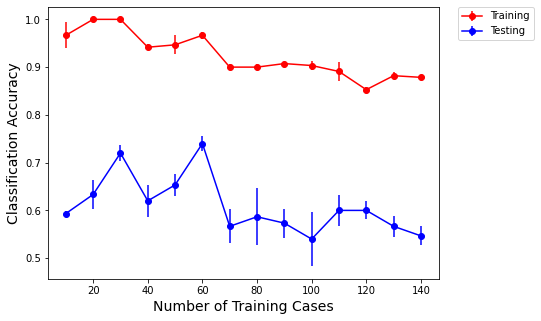

In [ ]:
#결과 plot (randomness 때문에 사람마다 다르게 나올 수 있음.)
plt.figure(1,figsize=(7,5))
plt.errorbar(np.dot(10,range(1,step+1)),avgTraining,yerr=stdTraining/np.sqrt(repeat),fmt='-o',color='r',label="Training")
plt.errorbar(np.dot(10,range(1,step+1)),avgTesting,yerr=stdTesting/np.sqrt(repeat), fmt='-o',color='b',label="Testing")

plt.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
plt.xlabel('Number of Training Cases',fontsize=14)
plt.ylabel('Classification Accuracy',fontsize=14)

plt.show()